In [25]:
import json
import os

# Load the dataset information from v2 json file
dataset_path = "/home/alimul/jupyter-workstation/datasets/Papaya"
json_path = os.path.join(dataset_path, "annotations/test_v2.json")

with open(json_path, 'r') as f:
    dataset_info = json.load(f)
    
# Print the keys to see the structure
print("Available keys in dataset_info:", dataset_info.keys())

Available keys in dataset_info: dict_keys(['info', 'cameras', 'days', 'records', 'annotations'])


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def read_bin_file(bin_file_path, header_info):
    """Read hyperspectral .bin file using header information"""
    height = header_info['height']
    width = header_info['width']
    bands = header_info['bands']
    
    data = np.fromfile(bin_file_path, dtype=np.float32)
    data = data.reshape(bands, height, width)
    return data

def visualize_band(data, band_idx, title=None):
    """Visualize a specific band from the hyperspectral image"""
    plt.figure(figsize=(10, 8))
    plt.imshow(data[band_idx], cmap='viridis')
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

# Load the dataset information
dataset_path = "/home/alimul/jupyter-workstation/datasets/Papaya"
json_path = os.path.join(dataset_path, "annotations/test_v2.json")

with open(json_path, 'r') as f:
    dataset_info = json.load(f)

# Let's first check the records for day_m4_01
sample_folder = "day_m4_01"

# Print records structure to understand how to access the data
print("Records structure:")
for record in dataset_info['records']:
    if record.get('day') == sample_folder:
        print(f"\nFound record for {sample_folder}")
        print(f"Record info: {record}")
        
        # Get the VIS file path and header info
        if 'VIS' in record:
            vis_file = record['VIS']
            vis_path = os.path.join(dataset_path, "VIS", sample_folder, vis_file)
            
            # Get header info from the record
            header_info = record.get('header', {})
            
            if os.path.exists(vis_path):
                # Read and visualize the data
                hsi_data = read_bin_file(vis_path, header_info)
                
                # Visualize a few different bands
                bands_to_show = [0, hsi_data.shape[0]//2, -1]  # First, middle, and last band
                for band_idx in bands_to_show:
                    visualize_band(hsi_data, band_idx, f"Band {band_idx}")
            else:
                print(f"File not found: {vis_path}")

Records structure:

Found record for day_m4_01
Record info: {'id': 105, 'fruit': 'Avocado', 'side': 'front', 'day': 'day_m4_01', 'camera_type': 'VIS_COR', 'files': {'header_file': 'Avocado/VIS_COR/day_m4_01/avocado_day_m4_01_22_front.hdr', 'data_file': 'Avocado/VIS_COR/day_m4_01/avocado_day_m4_01_22_front.bin'}}

Found record for day_m4_01
Record info: {'id': 106, 'fruit': 'Avocado', 'side': 'front', 'day': 'day_m4_01', 'camera_type': 'VIS', 'files': {'header_file': 'Avocado/VIS/day_m4_01/avocado_day_m4_01_22_front.hdr', 'data_file': 'Avocado/VIS/day_m4_01/avocado_day_m4_01_22_front.bin'}}

Found record for day_m4_01
Record info: {'id': 107, 'fruit': 'Avocado', 'side': 'back', 'day': 'day_m4_01', 'camera_type': 'VIS_COR', 'files': {'header_file': 'Avocado/VIS_COR/day_m4_01/avocado_day_m4_01_22_back.hdr', 'data_file': 'Avocado/VIS_COR/day_m4_01/avocado_day_m4_01_22_back.bin'}}

Found record for day_m4_01
Record info: {'id': 108, 'fruit': 'Avocado', 'side': 'back', 'day': 'day_m4_01', 'c

In [27]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import gc

In [28]:
# Cell 2: Load dataset info
def load_dataset_info(json_path='/home/alimul/jupyter-workstation/datasets/Papaya/annotations/train_all_v2.json'):
    """Load dataset information from JSON file"""
    with open(json_path, 'r') as f:
        return json.load(f)

# Load dataset info
dataset_info = load_dataset_info()

In [29]:
# Cell 3: Helper functions
def load_header(header_file):
    """Load and parse the header file"""
    header_info = {}
    try:
        with open(os.path.join('/home/alimul/jupyter-workstation/datasets', header_file), 'r') as f:
            for line in f:
                if '=' in line:
                    key, value = line.strip().split('=')
                    try:
                        header_info[key.strip()] = int(value.strip())
                    except ValueError:
                        header_info[key.strip()] = value.strip()
        return header_info
    except FileNotFoundError:
        print(f"Header file not found: {header_file}")
        return None

def load_data_efficiently(data_file):
    """Load the binary data file using memory mapping"""
    try:
        return np.memmap(os.path.join('/home/alimul/jupyter-workstation/datasets', data_file), dtype='float32', mode='r')
    except FileNotFoundError:
        print(f"Data file not found: {data_file}")
        return None

def normalize_band(band_data):
    """Normalize band data to 0-1 range"""
    min_val = np.min(band_data)
    max_val = np.max(band_data)
    return (band_data - min_val) / (max_val - min_val) if max_val > min_val else band_data

In [30]:
# Cell 4: Visualization functions
def visualize_hyperspectral_data(data, num_bands_to_show=5):
    """
    Visualize hyperspectral data in different bands
    Args:
        data: 3D array (height, width, bands)
        num_bands_to_show: number of bands to display
    """
    # Get total number of bands
    total_bands = data.shape[2]
    print(f"Total bands: {total_bands}")
    
    # Select evenly spaced bands to show
    band_indices = np.linspace(0, total_bands-1, num_bands_to_show, dtype=int)
    print(f"Showing bands: {band_indices}")
    
    # Create subplot grid
    fig, axes = plt.subplots(1, num_bands_to_show, figsize=(15, 3))
    fig.suptitle('Hyperspectral Image Bands')
    
    # Plot each selected band
    for i, band_idx in enumerate(band_indices):
        # Normalize band data for visualization
        band_data = data[:, :, band_idx]
        normalized_band = normalize_band(band_data)
        
        # Display the band
        axes[i].imshow(normalized_band, cmap='gray')
        axes[i].set_title(f'Band {band_idx}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Also show a false color composite
    fig, ax = plt.subplots(figsize=(8, 8))
    # Use three different bands for RGB channels
    rgb_bands = [int(total_bands*0.1), int(total_bands*0.5), int(total_bands*0.9)]
    print(f"RGB composite using bands: {rgb_bands}")
    
    rgb_image = np.dstack([
        normalize_band(data[:, :, rgb_bands[0]]),
        normalize_band(data[:, :, rgb_bands[1]]),
        normalize_band(data[:, :, rgb_bands[2]])
    ])
    
    ax.imshow(rgb_image)
    ax.set_title('False Color Composite')
    ax.axis('off')
    plt.show()

In [31]:
# Cell 5: Main loading and visualization function
def load_and_visualize_sample():
    """Load and visualize a sample papaya hyperspectral image"""
    print("Loading sample data...")
    
    # Find a papaya record
    papaya_records = [
        record for record in dataset_info['records'] 
        if record['fruit'] == 'Papaya' and record['camera_type'] == 'VIS'
    ]
    
    if not papaya_records:
        print("No papaya records found")
        return
    
    print(f"Found {len(papaya_records)} papaya records")
    
    # Use the first papaya record
    papaya_record = papaya_records[0]
    print(f"\nUsing record: {papaya_record}")
    
    # Load header
    header = load_header(papaya_record['files']['header_file'])
    if header is None:
        return
    
    print(f"\nHeader info: {header}")
    
    # Load data
    data = load_data_efficiently(papaya_record['files']['data_file'])
    if data is None:
        return
    
    # Reshape data according to header information
    try:
        reshaped_data = data.reshape(header['lines'], header['samples'], header['bands'])
        print(f"\nData shape: {reshaped_data.shape}")
        
        # Visualize the data
        visualize_hyperspectral_data(reshaped_data)
        
        # Clean up
        del data
        gc.collect()
        
    except Exception as e:
        print(f"Error reshaping data: {e}")

Loading sample data...
Found 256 papaya records

Using record: {'id': 4380, 'fruit': 'Papaya', 'side': 'front', 'day': 'day_m4_01', 'camera_type': 'VIS', 'files': {'header_file': 'Papaya/VIS/day_m4_01/papaya_day_m4_01_01_front.hdr', 'data_file': 'Papaya/VIS/day_m4_01/papaya_day_m4_01_01_front.bin'}}

Header info: {'samples': 272, 'lines': 435, 'bands': 224, 'header offset': 0, 'file type': 'ENVI Standard', 'data type': 4, 'interleave': 'bip', 'byte order': 0}

Data shape: (435, 272, 224)
Total bands: 224
Showing bands: [  0  55 111 167 223]


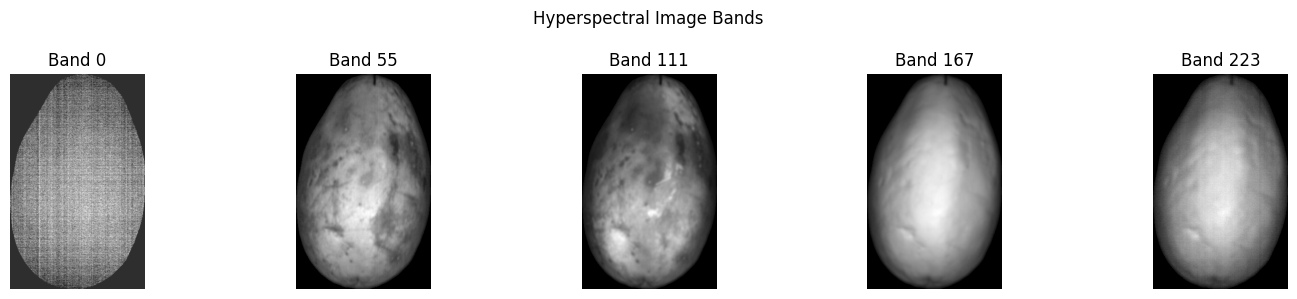

RGB composite using bands: [22, 112, 201]


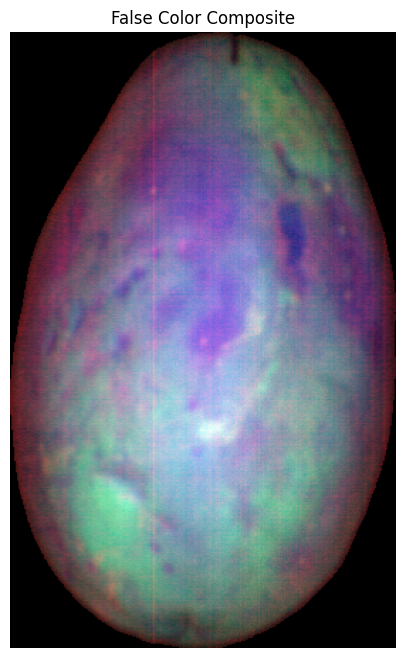

In [32]:
# Cell 6: Run the visualization
if __name__ == "__main__":
    load_and_visualize_sample()